# DSC 540
# Term Project
# Brian Mann

In [177]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [571]:
### Imported modules ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import html5lib
import re
import requests
from imdb import Cinemagoer
import sqlite3

In [179]:
### Sources ###

# Flat file
flat_file_url = 'https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews?select=rotten_tomatoes_movies.csv'
# Website
website_url = 'https://www.boxofficemojo.com/chart/top_lifetime_gross/'
# API
api_url = 'https://github.com/cinemagoer/cinemagoer'

## Milestone 2 - Flat File

### Reading in the Data

In [384]:
raw_rt = pd.read_csv('rotten_tomatoes_movies.csv')
raw_rt.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN
3,the_sore_losers_1997,Sore Losers,60.0,NaN,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy,NaN,NaN,NaN
4,dinosaur_island_2002,Dinosaur Island,70.0,NaN,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy,NaN,NaN,NaN


In [385]:
raw_rt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    143258 non-null  object 
 1   title                 142891 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   tomatoMeter           33877 non-null   float64
 4   rating                13991 non-null   object 
 5   ratingContents        13991 non-null   object 
 6   releaseDateTheaters   30773 non-null   object 
 7   releaseDateStreaming  79420 non-null   object 
 8   runtimeMinutes        129431 non-null  float64
 9   genre                 132175 non-null  object 
 10  originalLanguage      129400 non-null  object 
 11  director              139041 non-null  object 
 12  writer                90116 non-null   object 
 13  boxOffice             14743 non-null   object 
 14  distributor           23001 non-null   object 
 15  

In [386]:
raw_rt.isna().sum()

id                           0
title                      367
audienceScore            70010
tomatoMeter             109381
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                  4217
writer                   53142
boxOffice               128515
distributor             120257
soundMix                127341
dtype: int64

As we can see, the dataset contains over 140,000 rows and 16 columns. Unfortunately, many of the values are missing, so we will need to trim it down considerably. In the end, we are only going to focus on higher box-office earners. 

### Step 1: Change Column Titles

In [387]:
# get a list of all the column names
print(list(raw_rt.columns))

['id', 'title', 'audienceScore', 'tomatoMeter', 'rating', 'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'writer', 'boxOffice', 'distributor', 'soundMix']


In [388]:
# we will be using the 'rt' dataframe now, leaving the original dataframe intact
rt = raw_rt.copy()
# convert the columns to snake_case and reword some of them
rt.columns = ['id', 'title', 'audience_score', 'tomato_meter', 'rating', 'rating_contents', 
 'release_date_theaters', 'release_date_streaming', 'runtime', 'genre', 
 'language', 'director', 'writer', 'box_office', 'distributor', 'sound_mix']

In [389]:
rt.head()

,id,title,audience_score,tomato_meter,rating,rating_contents,release_date_theaters,release_date_streaming,runtime,genre,language,director,writer,box_office,distributor,sound_mix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
1,the_green_grass,The Green Grass,NaN,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Tiffany Edwards,Tiffany Edwards,NaN,NaN,NaN
2,love_lies,"Love, Lies",43.0,NaN,NaN,NaN,NaN,NaN,120.0,Drama,Korean,"Park Heung-Sik,Heung-Sik Park","Ha Young-Joon,Jeon Yun-su,Song Hye-jin",NaN,NaN,NaN
3,the_sore_losers_1997,Sore Losers,60.0,NaN,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,John Michael McCarthy,John Michael McCarthy,NaN,NaN,NaN
4,dinosaur_island_2002,Dinosaur Island,70.0,NaN,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Will Meugniot,John Loy,NaN,NaN,NaN


This step was more of a cosmetic change than anything. Changing the columns to snake_case only makes them more familiar for me to work with. I also changed 'runtimeMinutes' to 'runtime' and 'originalLanguage' to just 'language'. 

### Step 2: Omit Films without Box Office Data

In [390]:
# filter out the NaN values
rt = rt[-rt.box_office.isna()]

In [391]:
# show that it worked
rt.box_office.head(10)

5       $31.4M
12      $11.5K
17     $199.2K
20      $10.5K
31      $41.5K
63       $1.7M
82     $146.3M
87      $14.0M
88      $13.9M
107    $923.9K
Name: box_office, dtype: object

Since this project will mostly be focusing on blockbusters and other high-earning films, we have little use for any films with no box office data. All we did here is get rid of those rows. 

### Step 3: Convert Box Office Data to Numerical Values

In [392]:
# this function takes in text in abbreviated-dollars format
# and returns the equivalent float value
def convert_box_office(txt):
    unit = txt[-1]
    # check if there is a unit for thousands/millions/billions
    if unit not in ['K', 'M', 'B']:
        # if there is no unit at the end, take the full value
        num = txt[1::]
    else:
        # otherwise leave it off
        num = txt[1:len(txt)-1]
    # ensure that the the text is able to be converted
    try:
        num = float(num)
    except ValueError:
        print(f'{txt} could not be converted to a number')
        return txt
    # multiply the float by the appropiate power of ten and return
    if unit == 'K':
        return num*1000
    elif unit == 'M':
        return num*1000000
    elif unit == 'B':
        return num*1000000000
    else:
        return num

In [393]:
# apply the function to the dataframe
rt.loc[:, 'box_office'] = rt.box_office.apply(convert_box_office)

In [394]:
# make sure the box_office column is now reading as numeric
rt['box_office'] = pd.to_numeric(rt['box_office'], errors='coerce')

In [395]:
# list some of the highest earners
rt[['title', 'box_office']].sort_values(by='box_office', ascending=False).head(10)

,title,box_office
107161,Avengers: Endgame,858400000.0
142286,Spider-Man: No Way Home,814100000.0
71130,Top Gun: Maverick,718500000.0
18834,"Confess, Fletch",711600000.0
40710,Black Panther,700200000.0
104245,Avengers: Infinity War,678800000.0
85225,Avatar: The Way of Water,678300000.0
134058,Titanic,658800000.0
60631,Jurassic World,652600000.0
82701,Star Wars: The Last Jedi,620200000.0


This was the trickiest part of this milestone. Box office data was stored in an abbreviated format where thousands of dollars had a 'K' and millions had an 'M' (I don't believe there was any 'B', but I included it just in case). In order to alleviate this issue, a simple function was applied to the 'box_office' column so that all the values are now proper floats. 

One thing to note is that some of this data seems to be inaccurate. 'Confess, Fletch' only grossed \\$700K at the box office, not \\$700M. There must have been an error imputing some of this data onto the rotten tomatoes website at the time this data was scraped. Additionally, this box office data seems to only be including U.S. domestic gross, not international gross. 

### Step 4: Filter Out Low-Earning Box Office Films

In [396]:
rt = rt[rt.box_office > 50000000]

In [397]:
rt.shape

(1580, 16)

According to the Box Office Mojo tracker, the top 1,000 highest grossing films all have earned over \\$80M. Because this data was scrubbed one year ago, we will be be somewhat more generous and allow films that have earned above \\$50M to remain. We are left with around 1500 films. 

### Step 5: Fix/Filter the Remaining Missing Values

In [398]:
rt.isna().sum()

id                          0
title                       0
audience_score              0
tomato_meter                5
rating                    375
rating_contents           375
release_date_theaters      56
release_date_streaming     12
runtime                     1
genre                       0
language                    0
director                    3
writer                     19
box_office                  0
distributor                84
sound_mix                 226
dtype: int64

In [399]:
# check what films are missing critic ratings (tomato_meter)
rt[rt.tomato_meter.isna()].loc[:, ['title', 'box_office']]

,title,box_office
14420,Tyler Perry's Temptation: Confessions of a Mar...,52000000.0
73363,Wallace & Gromit: The Curse of the Were-Rabbit,56000000.0
75229,Strangers,52500000.0
115536,Disney's The Kid,69700000.0
142117,Snow White,87000000.0


In [400]:
# get rid of the films with no critic score
rt = rt[-rt.tomato_meter.isna()]

In [401]:
# check if there are any films without a release date
rt[rt.release_date_streaming.isna() & rt.release_date_theaters.isna()].shape[0]

0

In [402]:
# replace the one film without a runtime (Jumanji) with its proper runtime
rt.runtime.replace(np.nan, 104.0, inplace=True)

In [403]:
# find the films with a missing director
rt[rt.director.isna()][['title', 'release_date_theaters']]

,title,release_date_theaters
16599,City of Angels,1998-04-10
85957,Casper,1995-05-26
133687,Lemony Snicket's A Series of Unfortunate Events,2004-12-17


In [404]:
# get the mising indices
missing_indices = rt.index[rt.director.isna()].tolist()
# all of the films were directed by the same person, Brad Siberling
rt.loc[missing_indices, 'director'] = ['Brad Silberling']*3

In [405]:
# verify we have made the proper changes
rt.isna().sum()

id                          0
title                       0
audience_score              0
tomato_meter                0
rating                    373
rating_contents           373
release_date_theaters      54
release_date_streaming     12
runtime                     0
genre                       0
language                    0
director                    0
writer                     19
box_office                  0
distributor                82
sound_mix                 224
dtype: int64

We applied several additional changes to deal with missing values. First, we got rid of the films with no critic score (tomato_meter), as none of them seemed to be particularly high-grossing. Next, we verified that there were no films without a release date of some sort. Then, we replaced the one film with a missing runtime with its proper runtime (from imdb/wiki), as well as the films with missing directors with the proper director. 

### Step 6: Drop Duplicates & Examine the Results

In [406]:
# check the number of duplicate rows
rt.duplicated().sum()

10

In [407]:
# get rid of the duplicated rows
rt.drop_duplicates(inplace=True)

In [408]:
rt.describe()

,audience_score,tomato_meter,runtime,box_office
count,1565.000000,1565.000000,1565.000000,1.565000e+03
mean,67.013419,59.661981,113.714377,1.216684e+08
std,17.449575,24.974977,19.900059,9.351645e+07
min,16.000000,0.000000,43.000000,5.010000e+07
25%,54.000000,40.000000,99.000000,6.450000e+07
50%,68.000000,64.000000,111.000000,8.980000e+07
75%,82.000000,81.000000,125.000000,1.401000e+08
max,99.000000,100.000000,222.000000,8.584000e+08


In [409]:
rt.head()

,id,title,audience_score,tomato_meter,rating,rating_contents,release_date_theaters,release_date_streaming,runtime,genre,language,director,writer,box_office,distributor,sound_mix
82,paul_blart_mall_cop,Paul Blart: Mall Cop,43.0,34.0,PG,"['Mild Crude Humor', 'Language', 'Some Violence']",2009-01-16,2009-05-19,91.0,Comedy,English,Steve Carr,"Kevin James,Nick Bakay",146300000.0,Sony Pictures Entertainment,NaN
110,rookie_of_the_year,Rookie of the Year,52.0,38.0,NaN,NaN,1993-07-07,2002-01-29,103.0,"Kids & family, Comedy",English,Daniel Stern,Sam Harper,53100000.0,20th Century Fox,NaN
468,jurassic_world_dominion,Jurassic World Dominion,77.0,29.0,PG-13,"['Language', 'Intense Sequences of Action', 'S...",2022-06-10,2022-09-02,147.0,"Action, Adventure, Sci-fi, Mystery & thriller",English,Colin Trevorrow,"Emily Carmichael,Colin Trevorrow",376000000.0,Universal Pictures,"Dolby Digital, Dolby Atmos"
473,hansel_and_gretel_witch_hunters,Hansel & Gretel: Witch Hunters,53.0,16.0,R,"['Fantasy Horror Violence/Gore', 'Brief Sexual...",2013-01-25,2013-06-11,88.0,"Fantasy, Horror, Action, Adventure",English,Tommy Wirkola,Tommy Wirkola,55700000.0,"Paramount Pictures, Metro-Goldwyn-Mayer Distri...","SDDS, Datasat, Dolby Digital"
499,juno,Juno,88.0,94.0,PG-13,"['Mature Thematic Material', 'Language', 'Sexu...",2007-12-25,2008-04-15,96.0,"Comedy, Drama",English,Jason Reitman,Diablo Cody,143500000.0,Fox,"SDDS, Dolby Digital, DTS, Dolby SRD"


In [206]:
rt.shape

(1565, 16)

In [207]:
def make_histogram(df, col):
    plt.figure()
    df[col].hist()
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

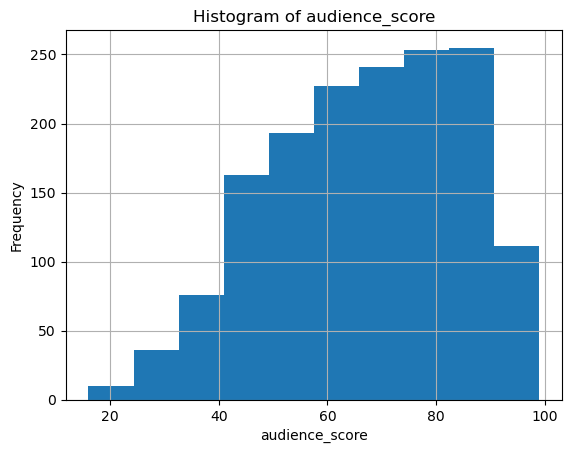

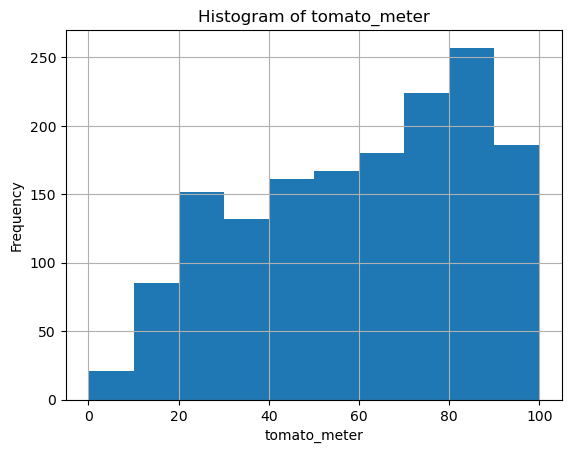

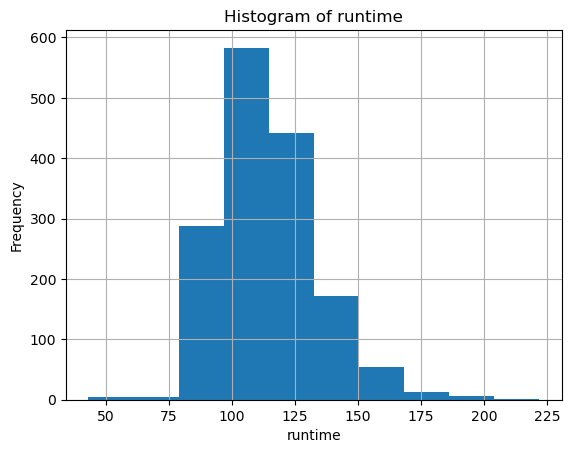

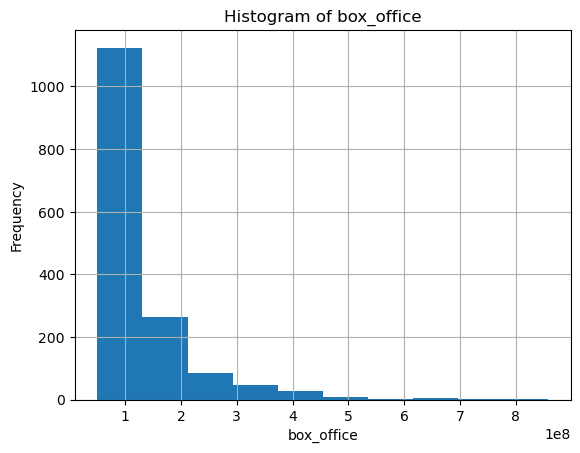

In [208]:
for col in ['audience_score', 'tomato_meter', 'runtime', 'box_office']:
    make_histogram(rt, col)

In [410]:
rt.to_csv('rotten_tomatoes_data.csv', index=False)

There were still 10 duplicate rows in the dataset, so we simply removed them. In the end, the final dataset contains 1565 films after these transformations, down from over 140,000!

### Concluding Thoughts and Implications

Overall, some significant changes were made to the data - the column names were changed, box office earnings were converted to floats, missing values were handled, duplicates were omitted, and the entire dataset was filtered down to about 1% of its original size. Some assumptions were definitely made when cleaning this data, e.g. that the data was inputted correctly, and that all of the highest-earning films actually contained box office data in this dataset. We know that some of the information is most likely incorrect, such as the film 'Confess, Fletch' earning 1,000x more than it actually did. This will be helpful when we need to merge and combine data data with our other datasets going forward. 

This data was sourced from a user of Kaggle who did a data scrape of the website Rotten Tomatoes. Although it is not verified by an official body, it can be assumed that the data is simply the same as what would have been publicly available at the time. Although I cannot speak on behalf of the Kaggle user, it seems that the data was scraped in an ethical way. Scraping like this could carry ethical implications if done improperly, such as using up too much of a site's bandwidth in a limited time. 

As for the transformations made here, I would say that there is very little to be worried about. We have simply taken the public Rotten Tomatoes data and distilled it into a smaller dataset only focused on higher box office earners. We can mitigate any potential ethical concerns with a disclaimer that this data was derived by a Kaggle user, and this data is reflective of the Rotten Tomatoes website during the early portion of the year 2023. 

## Milestone 3 - Website Data

### Step 1: Read in Domestic Film Data

In [54]:
# this function takes in a target url and returns a df of the first table on that site
def scrape_table(url):
    # create the response
    response = requests.get(url)
    # check the connection
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        # find the first instance of a table
        table = soup.find('table')
        # read the html into a dataframe
        df = pd.read_html(str(table))[0]
    else:
        print("Failed to retrieve the webpage")
        return None
    return df

In [55]:
url = "https://www.boxofficemojo.com/chart/top_lifetime_gross/"
# create a range of offsets to gather each entry in the df
offsets = ['?offset=' + str(x*200) for x in range(5)]
# create a list of each of the 5 dfs
dfs = [scrape_table(url + offset) for offset in offsets]
# concatenate the dfs into one larger df
dom = pd.concat(dfs, ignore_index=True)
dom.head()

,Rank,Title,Lifetime Gross,Year
0,1,Star Wars: Episode VII - The Force Awakens,"$936,662,225",2015
1,2,Avengers: Endgame,"$858,373,000",2019
2,3,Spider-Man: No Way Home,"$814,115,070",2021
3,4,Avatar,"$785,221,649",2009
4,5,Top Gun: Maverick,"$718,732,821",2022


In [56]:
dom.shape

(1000, 4)

Here we created a function to generate a dataframe from an html table, then we used it to scrape domestic film data from boxofficemojo.

### Step 2: Read in Worldwide Film Data

In [57]:
# do the same exact process with the worldwide film data
url = 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/'
w_dfs = [scrape_table(url + offset) for offset in offsets]
world = pd.concat(w_dfs, ignore_index=True)
world.head()

,Rank,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,1,Avatar,"$2,923,706,026","$785,221,649",26.9%,"$2,138,484,377",73.1%,2009
1,2,Avengers: Endgame,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
2,3,Avatar: The Way of Water,"$2,320,250,281","$684,075,767",29.5%,"$1,636,174,514",70.5%,2022
3,4,Titanic,"$2,264,750,694","$674,292,608",29.8%,"$1,590,458,086",70.2%,1997
4,5,Star Wars: Episode VII - The Force Awakens,"$2,071,310,218","$936,662,225",45.2%,"$1,134,647,993",54.8%,2015


In [58]:
world.shape

(1000, 8)

As we can see, both dfs have a total of 1000 entries. However, the worldwide film data contains a few more columns than the domestic data. 

Next we will process these dfs and merge them. 

### Step 3: Drop and Rename Columns

In [59]:
# drop the rank column, since we will be combining these dataframes
dom.drop(columns=['Rank'], inplace=True)
world.drop(columns=['Rank'], inplace=True)

In [60]:
# modify the domestic columns
dom.columns = ['title', 'domestic_gross', 'year']

In [61]:
# modify the worldwide columns, maintaining naming conventions with the domestic df
world.columns = ['title', 'world_gross', 'domestic_gross',
       'domestic_pct', 'foreign_gross', 'foreign_pct', 'year']

All we did here was drop an unnecessary column and replace all of the column names with a consistent snake_case. 

### Step 4: Replace Special Characters and Convert Columns to Numeric Dtypes

Both dfs contain several numerical columns with special characters such as '\\$' ',' '<' and '\%'.  We will get rid of these characters and convert these columns into the `float` type. 

In [62]:
# convert the box office gross into purely numeric strings
dom.domestic_gross = dom.domestic_gross.str.replace('$', '').str.replace(',', '')

In [63]:
# convert the strings into floats
dom.domestic_gross = dom.domestic_gross.astype(float)

In [64]:
dom.head()

,title,domestic_gross,year
0,Star Wars: Episode VII - The Force Awakens,936662225.0,2015
1,Avengers: Endgame,858373000.0,2019
2,Spider-Man: No Way Home,814115070.0,2021
3,Avatar,785221649.0,2009
4,Top Gun: Maverick,718732821.0,2022


In [65]:
# perform the same process for the worldwide df
for col in ['world_gross', 'domestic_gross', 'foreign_gross']:
    world[col] = world[col].astype('string')
    world[col] = world[col].str.replace('$', '').str.replace(',', '')

In [66]:
# perform the same process for the worldwide df for the percentages
for col in ['domestic_pct', 'foreign_pct']:
    world[col] = world[col].astype('string')
    world[col] = world[col].str.replace('%', '').str.replace('<', '').str.replace('>', '')

In addition to these special characters, there are also entries containing just a dash '-' that represent NaN values. We will replace them with 0's. 

In [67]:
# replace the dashes with zeroes
world[['domestic_pct', 'foreign_pct']] = world[['domestic_pct', 'foreign_pct']].replace('-', '0')

In [68]:
# replace the dashes with zeroes
world[['world_gross', 'domestic_gross', 'foreign_gross']] = world[['world_gross', 'domestic_gross', 
                                                                   'foreign_gross']].replace('-', '0')

In [69]:
# convert to float
for col in ['world_gross', 'domestic_gross', 'foreign_gross', 'domestic_pct', 'foreign_pct']:
    world[col] = world[col].astype(float)

In [70]:
world.head()

,title,world_gross,domestic_gross,domestic_pct,foreign_gross,foreign_pct,year
0,Avatar,2.923706e+09,785221649.0,26.9,2.138484e+09,73.1,2009
1,Avengers: Endgame,2.799439e+09,858373000.0,30.7,1.941066e+09,69.3,2019
2,Avatar: The Way of Water,2.320250e+09,684075767.0,29.5,1.636175e+09,70.5,2022
3,Titanic,2.264751e+09,674292608.0,29.8,1.590458e+09,70.2,1997
4,Star Wars: Episode VII - The Force Awakens,2.071310e+09,936662225.0,45.2,1.134648e+09,54.8,2015


### Step 5: Merge Worldwide and Domestic Data

In [71]:
# use an outer join to merge the two dfs, such that all films are still retained in the dataset
mojo = pd.merge(world, dom, how='outer', on=list(dom.columns))

In [72]:
mojo.head()

,title,world_gross,domestic_gross,domestic_pct,foreign_gross,foreign_pct,year
0,Avatar,2.923706e+09,785221649.0,26.9,2.138484e+09,73.1,2009
1,Avengers: Endgame,2.799439e+09,858373000.0,30.7,1.941066e+09,69.3,2019
2,Avatar: The Way of Water,2.320250e+09,684075767.0,29.5,1.636175e+09,70.5,2022
3,Titanic,2.264751e+09,674292608.0,29.8,1.590458e+09,70.2,1997
4,Star Wars: Episode VII - The Force Awakens,2.071310e+09,936662225.0,45.2,1.134648e+09,54.8,2015


In [73]:
mojo.tail()

,title,world_gross,domestic_gross,domestic_pct,foreign_gross,foreign_pct,year
1208,The Santa Clause 3: The Escape Clause,NaN,84500122.0,NaN,NaN,NaN,2006
1209,"Crazy, Stupid, Love.",NaN,84379584.0,NaN,NaN,NaN,2011
1210,Pinocchio,NaN,84254167.0,NaN,NaN,NaN,1940
1211,Scooby-Doo 2: Monsters Unleashed,NaN,84239132.0,NaN,NaN,NaN,2004
1212,Alien,NaN,84206106.0,NaN,NaN,NaN,1979


Here an outer join was performed to merge the domestic and worldwide box office data. The outer join helps to keep all of the films across both datasets, as we we would like to retain as much information as possible until the final merges are accomplished across all our data sources. 

### Step 6: Drop Duplicates and Fix Years

When making the final checks for anomilies in the dataset, it appeared that there were some films that were duplicated due to having years that were off by one. So, the domestic gross and title were the exact same, and yet the year was different, thus the two rows failed to merge into one row. 

We will remove these duplicated rows and fix the years to be the correct year. 

In [74]:
# find the rows that we want to keep (the ones with the world-wide data have more info)
mojo[mojo.duplicated(subset=['title', 'domestic_gross'], keep='last')]

,title,world_gross,domestic_gross,domestic_pct,foreign_gross,foreign_pct,year
467,Prince of Persia: The Sands of Time,336365676.0,90759676.0,27.0,245606000.0,73.0,2009
616,We're the Millers,269994119.0,150394119.0,55.7,119600000.0,44.3,2012
654,The Village,256697520.0,114197520.0,44.5,142500000.0,55.5,2003
659,Get Out,255751443.0,176196665.0,68.9,79554778.0,31.1,2016
766,Taken,226837760.0,145000989.0,63.9,81836771.0,36.1,2008


In [75]:
# make the necessary drops 
# (notice that we need to keep the opposite entries here than the duplicated() entries)
mojo.drop_duplicates(subset=['title', 'domestic_gross'], keep='first', inplace=True)

In [76]:
# check that there are no more duplicates by title and year
mojo[mojo.duplicated(subset=['title', 'year'])].shape

(0, 7)

In [77]:
# get a list of the films needing updating
# (for some reason Taken had a correct year, so we ignore it)
wrong_years = ['Prince of Persia: The Sands of Time', 'We\'re the Millers', 'The Village', 'Get Out']

In [78]:
# add one to these years
mojo.loc[mojo['title'].isin(wrong_years), 'year'] += 1

In [79]:
# check that the changes were made
mojo.loc[mojo['title'].isin(wrong_years), ['title', 'year']]

,title,year
467,Prince of Persia: The Sands of Time,2010
616,We're the Millers,2013
654,The Village,2004
659,Get Out,2017


In [80]:
# find the size of the resulting merged dataset
mojo.shape

(1208, 7)

In [125]:
mojo = mojo.reset_index(drop=True)

In [211]:
mojo.to_csv('mojo_data.csv', index=False)

### Concluding Thoughts and Implications

Overall, there were relatively few changes made to the two datasets. The biggest changes were modifying the string values for numerical quantities and turning them into float datatypes, as well as getting rid of duplicate entries. Most of the difficulties were in scraping the data and merging it. There are few risks that could come of these transformations, as the information is still largely the same information as is already contained on the website. We assumed that films would have the same domestic gross values across both datasets if they were also contained in both datasets. This assumption seemed to largely hold true, aside from some weird quirks in the years column. It was also assumed that the rank column would be unnecessary, since the ranks would likely change after transformtation. 

The data for this phase of the project was sourced from Boxofficemojo, which is a subsidiary of IMDB - the largest and most widely recognized database for film and visual media. The data was scraped in an ethical way, as there were relatively few requests being made in a given amount of time. However, the guidelines for IMDB do require expressly written consent for extensive data mining or webscraping. The guidelines also forbid the reproduction and exploitation of their data for a commercial purpose, but as this is an educational project, that does not apply. I will need to section out my scraping for the next phase of the project, since a significantly larger number of requests will need to be made.

## Milestone 4 - API Data

### Step 1: Extract the Data into a Dataframe

In [163]:
# this function takes in a search query for a movie and returns the movie ID
def get_imdb_id(info):
    try:
        # search for the movie title
        search_results = cg.search_movie(info)
        # return the IMDB ID of the first search result
        return search_results[0].movieID
    except Exception as e:
        print(f"Error finding IMDB ID for '{info}': {e}")
        return None

In [139]:
# this function takes in a dictionary, movie data, and a column name
# it then tries to add the movie data for that item to the dictionary
def add_film_item(dct, movie, item):
    try:
        dct[item] = movie[item]
    except:
        dct[item] = np.nan

In [138]:
# this function takes in a dictionary, movie data, and a column name
# it then tries to add the box office data for that particular item to the dictionary
def add_box_office(dct, movie, item):
    try:
        bo = movie['box office']
        # call the add_film_item function specifically for box office data
        add_film_item(dct, bo, item)
    except:
        dct[item] = np.nan

In [137]:
# this function takes in a dictionary, movie data, and a column name
# it then adds a list of up to three values to the dictionary based on the movie data
def add_film_staff(dct, movie, item):
    try:
        # check the size of the entry
        size = len(movie[item])
        # take at most three values
        if size > 3:
            size = 3
        # add the list to the dictionary
        dct[item] = [f['name'] for f in movie[item][:size]]
    except:
        dct[item] = np.nan 

In [164]:
# this function takes in a search query and gathers the first result from IMDB
# it then adds relevant information about the given film to a dictionary
def get_film_dict(query):
    # create an empty dict
    film_dct = dict()
    # get the IMDB ID for the movie
    num = get_imdb_id(query)
    # check if anything is retrieved
    if num is None:
        return None
    # gather the data for the given movie based on the ID number
    film = cg.get_movie(num)
    # go through various sets of columns, adding the data to the dictionary
    for col in movie_columns:
        add_film_item(film_dct, film, col)
    for col in box_info:
        add_box_office(film_dct, film, col)
    for col in entities:
        add_film_staff(film_dct, film, col)
    # return the final dictionary
    return film_dct

In [219]:
# this function takes in a DF of movies and returns a list of dictionaries 
# of information related to each movie
def film_dict_list(df):
    # create an empty list of dictionaries
    dct_list = list()
    # iterate over the rows of the df
    for idx, row in df.iterrows():
        # get the title and year the film was made and make it into a search query
        title, year = row['title'], str(row['year'])
        query = title + ' ' + year
        # get the dictionary of film data for the query
        film_dct = get_film_dict(query)
        # if nothing was gathered, try a secondary search with just the title
        if film_dct is None:
            film_dct = get_film_dict(title)
            # most likely, the IMDB server detected that a scraper was being used
            print(f'IMBD detected a webscraper for {title} {year}!')
        # add the original title to the DF as a measure for future merging
        film_dct['mojo_title'] = title
        # add the dictionary to the list
        dct_list.append(film_dct)
        # check that each movie is getting added
        print(f'Movie #{idx+1} Complete!')
    return dct_list

In [166]:
# this function takes in a list of dictionaries and a given index number
# it then produces a DF and a CSV file based on the data
def get_next_csv(dct_list, n):
    name = 'cinemagoer_data' + str(n) + '.csv'
    df = pd.DataFrame(dct_list)
    df.to_csv(name, index=False)
    print('*'*50)
    # check that each CSV is getting added
    print(f'CSV #{n} SUCCESSFULLY ADDED')
    print('*'*50)

In [170]:
# this function takes in a DF of movie data, then creates a series of CSVs
# with a limit of 50 entries per CSV file
# it is meant to work with the mojo df produced during milestone 3
def make_film_csvs(df, start=0):
    for i in range(start, 24):
        # get the current slice of our DF
        cur_df = df[i*50:(i+1)*50]
        # generate the list of dictionaries and produce the next CSV file
        dct_list = film_dict_list(cur_df)
        get_next_csv(dct_list, i)
    # do the same thing with the last few entries in the DF
    cur_df = df[1200:]
    dct_list = film_dict_list(cur_df)
    get_next_csv(dct_list, 24)


In [128]:
# these are the columns that can be called directly with no further processing
movie_columns = ['imdbID', 'title', 'genre', 'runtime', 'country', 'language', 
        'original air date', 'rating', 'votes', 'year', 'kind']

In [129]:
# these columns need to be extracted into lists of values
entities = ['cast', 'director', 'production companies']

In [130]:
# these columns will also need to be extracted separately
box_info = ['Budget', 'Opening Weekend United States', 'Cumulative Worldwide Gross']

In [131]:
# set and instance of the Cinemagoer API to a variable
cg = Cinemagoer()

In [ ]:
# create a series CSVs that help gather all of the info from the API calls 
make_film_csvs(mojo)

In [172]:
# this function takes in all of the CSV files we have made and 
# returns a DF that includes all of the data
def make_big_df():
    fname = 'cinemagoer_data'
    cgdat = pd.read_csv(fname + '0.csv')
    # iterate over each CSV, concatenating the data to a DF
    for i in range(1, 25):
        full = fname + str(i) + '.csv'
        cur_df = pd.read_csv(full)
        cgdat = pd.concat([cgdat, cur_df], axis=0, ignore_index=True)
    return cgdat

In [173]:
# make the overall DF
cgdat = make_big_df()

In [176]:
# add a CSV file of the entire data
cgdat.to_csv('cinemagoer_combined.csv', index=False)

In [212]:
cgdat.head()

,imdbID,title,genre,runtime,country,language,original air date,rating,votes,year,kind,Budget,Opening Weekend United States,Cumulative Worldwide Gross,cast,director,production companies,mojo_title
0,499549,Avatar,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",['162'],['United States'],"['English', 'Spanish']",18 Dec 2009 (USA),7.9,1387972.0,2009,movie,"$237,000,000 (estimated)","$77,025,481, 20 Dec 2009","$2,787,965,087, 13 Feb 2015","['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",['James Cameron'],"['Twentieth Century Fox', 'Dune Entertainment'...",Avatar
1,4154796,Avengers: Endgame,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",['181'],['United States'],"['English', 'Japanese', 'Xhosa', 'German']",26 Apr 2019 (USA),8.4,1268310.0,2019,movie,"$356,000,000 (estimated)","$357,115,007, 28 Apr 2019","$2,797,800,564","['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...","['Anthony Russo', 'Joe Russo']","['Marvel Studios', 'Walt Disney Pictures']",Avengers: Endgame
2,1630029,Avatar: The Way of Water,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",['192'],['United States'],['English'],16 Dec 2022 (USA),7.5,495694.0,2022,movie,"$350,000,000 (estimated)",NaN,"$2,248,370,228","['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",['James Cameron'],"['20th Century Studios', 'TSG Entertainment', ...",Avatar: The Way of Water
3,120338,Titanic,"['Drama', 'Romance']",['194'],"['United States', 'Mexico']","['English', 'Swedish', 'Italian', 'French']",19 Dec 1997 (USA),7.9,1282461.0,1997,movie,"$200,000,000 (estimated)","$28,638,131, 21 Dec 1997","$2,186,772,302, 11 Aug 2015","['Leonardo DiCaprio', 'Kate Winslet', 'Billy Z...",['James Cameron'],"['Twentieth Century Fox', 'Paramount Pictures'...",Titanic
4,2488496,Star Wars: Episode VII - The Force Awakens,"['Action', 'Adventure', 'Sci-Fi']",['138'],['United States'],['English'],18 Dec 2015 (USA),7.8,974702.0,2015,movie,"$245,000,000 (estimated)","$247,966,675, 20 Dec 2015","$2,068,223,624, 10 Jul 2016","['Harrison Ford', 'Mark Hamill', 'Carrie Fisher']",['J.J. Abrams'],"['Lucasfilm', 'Bad Robot']",Star Wars: Episode VII - The Force Awakens


Quite a lot went into this step. For every movie in the Mojo dataset, a search query was made to the IMDB website. Once a valid search was made, the ID of that particular movie was extracted. Using that ID, a series of information was gathered and placed into a dictionary using the API. Each dictionary was then added to a list. Using that list, a dataframe and a CSV file was made. This process was repeated for all 1200+ movies, ultimately producing an overall Dataframe and CSV file. Note that the CSV file was not extracted directly from the website. CSV files were mainly used as a means to ensure that API calls would not have to be repeated if any errors occurred during requests to the API. 

### Step 2: Drop Non-Film Entries

In [217]:
# check how many entries returned non-movies
len(cgdat[cgdat.kind != 'movie'])

24

In [222]:
# only keep columns that are movies
cgdat = cgdat[cgdat.kind == 'movie']

Movies were queried by a 'title + year' format on the IMDB website. Unfortunately, since only the first result was returned for each movie, not all of the searches may have returned what was desired. That is why we kept in the 'movie' column, so that they could be filtered out now. However, this does not take into account the case where a separate movie was returned instead of the target movie. That will most likely be addressed in the final milestone. 

### Step 3: Change Column Names

In [223]:
cgdat.columns

Index(['imdbID', 'title', 'genre', 'runtime', 'country', 'language',
       'original air date', 'rating', 'votes', 'year', 'kind', 'Budget',
       'Opening Weekend United States', 'Cumulative Worldwide Gross', 'cast',
       'director', 'production companies', 'mojo_title'],
      dtype='object')

In [224]:
cgdat.columns = ['imdb_id', 'title', 'genre', 'runtime', 'country', 'language',
       'air_date', 'rating', 'votes', 'year', 'kind', 'budget',
       'opening_weekend', 'worldwide_gross', 'cast',
       'director', 'production_company', 'mojo_title']

Column names were changed here to keep a consistent, shorter snake_case format. 

### Step 4: Convert Lists to Strings

In [228]:
# these columns currently store values in list format
lst_vars = cgdat[['genre','runtime','country','language','cast','director','production_company']]

In [238]:
# use regex to replace the characters [ ] and ' with empty spaces
for col in lst_vars:
    lst_vars[col] = lst_vars[col].str.replace('[\[\]\']', '', regex=True)

In [240]:
cgdat[lst_vars.columns] = lst_vars

In [245]:
# set runtime to be a float
cgdat['runtime'] = cgdat['runtime'].astype('float')

In [246]:
cgdat[lst_vars.columns].head()

,genre,runtime,country,language,cast,director,production_company
0,"Action, Adventure, Fantasy, Sci-Fi",162.0,United States,"English, Spanish","Sam Worthington, Zoe Saldana, Sigourney Weaver",James Cameron,"Twentieth Century Fox, Dune Entertainment, Lig..."
1,"Action, Adventure, Drama, Sci-Fi",181.0,United States,"English, Japanese, Xhosa, German","Robert Downey Jr., Chris Evans, Mark Ruffalo","Anthony Russo, Joe Russo","Marvel Studios, Walt Disney Pictures"
2,"Action, Adventure, Fantasy, Sci-Fi",192.0,United States,English,"Sam Worthington, Zoe Saldana, Sigourney Weaver",James Cameron,"20th Century Studios, TSG Entertainment, Light..."
3,"Drama, Romance",194.0,"United States, Mexico","English, Swedish, Italian, French","Leonardo DiCaprio, Kate Winslet, Billy Zane",James Cameron,"Twentieth Century Fox, Paramount Pictures, Lig..."
4,"Action, Adventure, Sci-Fi",138.0,United States,English,"Harrison Ford, Mark Hamill, Carrie Fisher",J.J. Abrams,"Lucasfilm, Bad Robot"


There were several columns that returned information in the form of lists of strings. Here we simply removed the characters that formed the lists, apart from the commas. We also changed the runtime variable to be a float.

### Step 5: Change Air Date to a Datetime Object

In [256]:
# replace the text at the end of the air date with empty spaces
cgdat.air_date = cgdat.air_date.str.replace(r'\(.*\)$', '', regex=True).str.strip()

In [263]:
# use the pd.to_datetime function to convert the column to datetime values
cgdat.air_date = pd.to_datetime(cgdat['air_date'], dayfirst=True, format='%d %b %Y')

The Air Date column was initially formatted like 'Date + (Country)'. We got rid of the country part of the string and simply kept the date, then converted it into a datetime object. 

### Step 6: Change Monetary Entries to Floats

In [273]:
# get the box office columns
num_vars = cgdat[['budget','opening_weekend','worldwide_gross']]

In [280]:
num_vars.head()

,budget,opening_weekend,worldwide_gross
0,"$237,000,000 (estimated)","$77,025,481, 20 Dec 2009","$2,787,965,087, 13 Feb 2015"
1,"$356,000,000 (estimated)","$357,115,007, 28 Apr 2019","$2,797,800,564"
2,"$350,000,000 (estimated)",NaN,"$2,248,370,228"
3,"$200,000,000 (estimated)","$28,638,131, 21 Dec 1997","$2,186,772,302, 11 Aug 2015"
4,"$245,000,000 (estimated)","$247,966,675, 20 Dec 2015","$2,068,223,624, 10 Jul 2016"


In [327]:
# this function takes in a string of monetary information
# and returns a float value of just the money
def convert_dollars(s):
    try:
        # first get rid of the dollar sign and commas
        s = s.replace(',', '').replace('$', '')
        # now gather only the digits that begin the string
        s = re.match(r'^(\d+)', s).group()
        # convert it to a float
        return float(s)
    except:
        return np.nan

In [328]:
# apply the convert_dollars function to each of the box office columns
for col in num_vars:
    num_vars[col] = num_vars[col].apply(convert_dollars)

In [331]:
cgdat[num_vars.columns] = num_vars

In [333]:
cgdat.head()

,imdb_id,title,genre,runtime,country,language,air_date,rating,votes,year,kind,budget,opening_weekend,worldwide_gross,cast,director,production_company,mojo_title
0,499549,Avatar,"Action, Adventure, Fantasy, Sci-Fi",162.0,United States,"English, Spanish",2009-12-18,7.9,1387972.0,2009,movie,237000000.0,77025481.0,2.787965e+09,"Sam Worthington, Zoe Saldana, Sigourney Weaver",James Cameron,"Twentieth Century Fox, Dune Entertainment, Lig...",Avatar
1,4154796,Avengers: Endgame,"Action, Adventure, Drama, Sci-Fi",181.0,United States,"English, Japanese, Xhosa, German",2019-04-26,8.4,1268310.0,2019,movie,356000000.0,357115007.0,2.797801e+09,"Robert Downey Jr., Chris Evans, Mark Ruffalo","Anthony Russo, Joe Russo","Marvel Studios, Walt Disney Pictures",Avengers: Endgame
2,1630029,Avatar: The Way of Water,"Action, Adventure, Fantasy, Sci-Fi",192.0,United States,English,2022-12-16,7.5,495694.0,2022,movie,350000000.0,NaN,2.248370e+09,"Sam Worthington, Zoe Saldana, Sigourney Weaver",James Cameron,"20th Century Studios, TSG Entertainment, Light...",Avatar: The Way of Water
3,120338,Titanic,"Drama, Romance",194.0,"United States, Mexico","English, Swedish, Italian, French",1997-12-19,7.9,1282461.0,1997,movie,200000000.0,28638131.0,2.186772e+09,"Leonardo DiCaprio, Kate Winslet, Billy Zane",James Cameron,"Twentieth Century Fox, Paramount Pictures, Lig...",Titanic
4,2488496,Star Wars: Episode VII - The Force Awakens,"Action, Adventure, Sci-Fi",138.0,United States,English,2015-12-18,7.8,974702.0,2015,movie,245000000.0,247966675.0,2.068224e+09,"Harrison Ford, Mark Hamill, Carrie Fisher",J.J. Abrams,"Lucasfilm, Bad Robot",Star Wars: Episode VII - The Force Awakens


In this final step, we extracted only the dollar amount for each of the box-office related variables and converted them into floats. 

### Concluding Thoughts and Implications

The bulk of the time spent on this milestone of the project was in producing the proper functions for making API calls and gathering the necessary data from those calls. Once all the data was gathered, some minor cosmetic changes were made to the data. Numeric entries were all converted to floats, and lists of data were converted into comma-separated strings. Not all of the cast/directors/production companies were kept simply for space concerns. We assume we wouldn't need to know all 100+ people that acted in a particular film to get a sufficient picture of it. We also assume so far that all of the films that were searched returned the correct film from each respective query. This has the potential of giving incorrect data during our final analysis. However, this will be touched on in the final milestone during cross-validation and merging. 

Data from this milestone was sourced from IMDB via the Cinemagoer API. As mentioned in the previous milestone, IMDB is the largest and most trusted source for film and media data. IMDB stipulates that webcrawlers must be used with explicit permission, however, as this project uses the Cinemagoer API to communicate with IMDB, the same regulations need not necessarily apply. Cinemagoer ensures that a low volume of API calls to IMDB are taken at a given time, so as not to overload their servers. Despite this, IMDB was still able to determine some searches were taken via machine. This required another backup search to be placed to get around this issue. 

## Milestone 5 - Merging the Data & Visualizations

### Step 1: Merging the Data into a Final Dataframe

In [346]:
# change title column for ease of merging
mojo.columns = ['mojo_title', 'world_gross', 'domestic_gross', 'domestic_pct',
       'foreign_gross', 'foreign_pct', 'year']

In [355]:
# merge the dataframes based on title and year
imdb_merged = pd.merge(mojo, cgdat, on=['mojo_title', 'year'], how='outer')

In [360]:
# make sure that most of the titles match the intended merge
imdb_merged[imdb_merged.mojo_title != imdb_merged.title].shape[0]

30

In [361]:
# get rid of mismatches
imdb_merged = imdb_merged[imdb_merged.mojo_title == imdb_merged.title]

In [369]:
# drop duplicate title column
imdb_merged.drop(columns='title', inplace=True)

In [371]:
# reset the index
imdb_merged.reset_index(drop=True, inplace=True)

In [411]:
# change 'release_date column' to match the 'air_date' column
rt.columns = ['id', 'title', 'audience_score', 'tomato_meter', 'rating',
       'rating_contents', 'air_date', 'release_date_streaming',
       'runtime', 'genre', 'language', 'director', 'writer', 'box_office',
       'distributor', 'sound_mix']

In [413]:
# convert the two date columns to datetime format
for col in ['air_date', 'release_date_streaming']:
    rt[col] = pd.to_datetime(rt[col], format='%Y-%m-%d')

In [742]:
# merge the rotten tomatoes and IMDB datasets based on the air date and run time
# this was the simplest method of merging the datasets without involving title matching 
finale = pd.merge(rt, imdb_merged, on=['air_date', 'runtime'], how='right')

In [743]:
# get the final shape of the merged data
finale.shape

(1185, 36)

In [744]:
# find out which films were not actually merged correctly by visually comparing titles
finale[finale.title != finale.mojo_title][['title', 'mojo_title']].dropna()

,title,mojo_title
19,Star Wars: The Last Jedi,Star Wars: Episode VIII - The Last Jedi
30,Spider-Man: Far From Home,Spider-Man: Far from Home
79,Star Wars: Episode III -- Revenge of the Sith,Star Wars: Episode III - Revenge of the Sith
86,The Twilight Saga: Breaking Dawn Part 2,The Twilight Saga: Breaking Dawn - Part 2
129,The Twilight Saga: Breaking Dawn Part 1,The Twilight Saga: Breaking Dawn - Part 1
170,Ant-Man and The Wasp,Ant-Man and the Wasp
205,Mission: Impossible 2,Mission: Impossible II
256,Ant-Man and The Wasp: Quantumania,Ant-Man and the Wasp: Quantumania
262,It: Chapter Two,It Chapter Two
285,Pokémon Detective Pikachu,Pokémon: Detective Pikachu


In [745]:
# list the incorrectly merged films with their respective index numbers
finale.iloc[[375, 487, 528, 808, 872, 948, 1176], :][['title', 'mojo_title']]

,title,mojo_title
375,Valkyrie,Slumdog Millionaire
487,Due Date,Megamind
528,Assassin's Creed,Passengers
808,Green Book,Creed II
872,The Intern,Everest
948,Hairspray,I Now Pronounce You Chuck & Larry
1176,Cowboys & Aliens,"Crazy, Stupid, Love."


In [746]:
# drop the incorrect rows
# finale.drop([375, 487, 528, 808, 872, 948, 1176], inplace=True)

In [748]:
# adjust title names to differeniate between the RT data and the IMDB data
finale.columns = ['id_rt', 'title_rt', 'audience_score_rt', 'rating_rt', 'mpaa_rating',
       'mpaa_contents', 'air_date', 'release_date_streaming', 'runtime',
       'genre_rt', 'language_rt', 'director_rt', 'writer', 'box_office',
       'distributor', 'sound_mix', 'title_imdb', 'world_gross',
       'domestic_gross', 'domestic_pct', 'foreign_gross', 'foreign_pct',
       'year', 'id_imdb', 'genre_imdb', 'country', 'language_imdb', 'rating_imdb',
       'votes', 'kind', 'budget', 'opening_weekend', 'worldwide_gross', 'cast',
       'director_imdb', 'production_company']

In [749]:
# get rid of unwanted characters from the mpaa_contents column
finale['mpaa_contents'] = finale['mpaa_contents'].str.replace('[\[\]\']', '', regex=True)

In [750]:
# set the global gross to whatever the maximum value of the other box office earnings is
# (some films only seem to contain domestic data)
finale['global_gross'] = np.nanmax(finale[['world_gross', 'worldwide_gross', 
                                           'domestic_gross', 'foreign_gross']].values, axis=1)

In [751]:
# ensure that global gross was input correctly
finale[['world_gross', 'worldwide_gross', 'global_gross']]

,world_gross,worldwide_gross,global_gross
0,2.923706e+09,2.787965e+09,2.923706e+09
1,2.799439e+09,2.797801e+09,2.799439e+09
2,2.320250e+09,2.248370e+09,2.320250e+09
3,2.264751e+09,2.186772e+09,2.264751e+09
4,2.071310e+09,2.068224e+09,2.071310e+09
...,...,...,...
1180,NaN,2.036306e+08,2.036306e+08
1181,NaN,2.619304e+08,2.619304e+08
1182,NaN,2.291633e+08,2.291633e+08
1183,NaN,1.614484e+08,1.614484e+08


In [752]:
# drop the redundant worldwide earnings columns
finale.drop(columns=['world_gross', 'worldwide_gross'], inplace=True)

In [753]:
# demonstrate the final dataframe
finale.head()

,id_rt,title_rt,audience_score_rt,rating_rt,mpaa_rating,mpaa_contents,air_date,release_date_streaming,runtime,genre_rt,...,language_imdb,rating_imdb,votes,kind,budget,opening_weekend,cast,director_imdb,production_company,global_gross
0,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-18,NaT,162.0,NaN,...,"English, Spanish",7.9,1387972.0,movie,237000000.0,77025481.0,"Sam Worthington, Zoe Saldana, Sigourney Weaver",James Cameron,"Twentieth Century Fox, Dune Entertainment, Lig...",2.923706e+09
1,avengers_endgame,Avengers: Endgame,90.0,94.0,PG-13,"Sequences of Sci-Fi Violence, Action, Some Lan...",2019-04-26,2019-07-30,181.0,"Action, Adventure, Fantasy, Sci-fi",...,"English, Japanese, Xhosa, German",8.4,1268310.0,movie,356000000.0,357115007.0,"Robert Downey Jr., Chris Evans, Mark Ruffalo","Anthony Russo, Joe Russo","Marvel Studios, Walt Disney Pictures",2.799439e+09
2,avatar_the_way_of_water,Avatar: The Way of Water,92.0,76.0,PG-13,"Partial Nudity, Intense Action, Sequences of S...",2022-12-16,2023-03-28,192.0,"Sci-fi, Adventure, Action, Fantasy",...,English,7.5,495694.0,movie,350000000.0,NaN,"Sam Worthington, Zoe Saldana, Sigourney Weaver",James Cameron,"20th Century Studios, TSG Entertainment, Light...",2.320250e+09
3,NaN,NaN,NaN,NaN,NaN,NaN,1997-12-19,NaT,194.0,NaN,...,"English, Swedish, Italian, French",7.9,1282461.0,movie,200000000.0,28638131.0,"Leonardo DiCaprio, Kate Winslet, Billy Zane",James Cameron,"Twentieth Century Fox, Paramount Pictures, Lig...",2.264751e+09
4,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-18,NaT,138.0,NaN,...,English,7.8,974702.0,movie,245000000.0,247966675.0,"Harrison Ford, Mark Hamill, Carrie Fisher",J.J. Abrams,"Lucasfilm, Bad Robot",2.071310e+09


In [754]:
# get the shape of the final dataframe
finale.shape

(1178, 35)

There was little difficulty in merging the API dataset with the website dataset, as both were extracted from IMDB. There were a few dozen films that were not properly merged, most likely due to minor issues with search results from the Cinemagoer API. On the other hand, it was much more difficult to find a simple way to merge the IMDB data with the Rotten Tomatoes data. Both of these sites use different conventions for film titles, genres, personnel, ratings, etc. After some thought, it was determined that the simplest way of collecting the maximum amount of films without visually inspecting titles was to use the air date and runtime as the basis for the merge. Unfortunately, only about half (~600 / ~1200) of the films from the IMDB merged dataset were properly merged with Rotten Tomatoes films using this method. The mismatched titles a few lines of code above demonstrate the difficulties with the two naming conventions. 

### Step 2: Storing the Data in a Database

In [545]:
# create a sqlite database and open a connection
db = 'film_db'
conn = sqlite3.connect(db)
c = conn.cursor()

In [531]:
# put the dataframes and their respective names in a list
dfs = [rt, mojo, cgdat, finale]
names = ['rt', 'mojo', 'cgdat', 'finale']

In [532]:
# place each of these dataframes into the database as a SQL table
for name, df in zip(names, dfs):
    df.to_sql(name, conn, if_exists='replace', index=False)

In [546]:
# test that each table was input correctly into the database
for name in names:
    for val in c.execute(f'SELECT * FROM {name} LIMIT 1'):
        print(val)
        print('*'*50)

('paul_blart_mall_cop', 'Paul Blart: Mall Cop', 43.0, 34.0, 'PG', "['Mild Crude Humor', 'Language', 'Some Violence']", '2009-01-16 00:00:00', '2009-05-19 00:00:00', 91.0, 'Comedy', 'English', 'Steve Carr', 'Kevin James,Nick Bakay', 146300000.0, 'Sony Pictures Entertainment', None)
**************************************************
('Avatar', 2923706026.0, 785221649.0, 26.9, 2138484377.0, 73.1, 2009)
**************************************************
(499549, 'Avatar', 'Action, Adventure, Fantasy, Sci-Fi', 162.0, 'United States', 'English, Spanish', '2009-12-18 00:00:00', 7.9, 1387972.0, 2009, 'movie', 237000000.0, 77025481.0, 2787965087.0, 'Sam Worthington, Zoe Saldana, Sigourney Weaver', 'James Cameron', 'Twentieth Century Fox, Dune Entertainment, Lightstorm Entertainment', 'Avatar')
**************************************************
(None, None, None, None, None, None, '2009-12-18 00:00:00', None, 162.0, None, None, None, None, None, None, None, 'Avatar', 785221649.0, 26.9, 213848437

In [811]:
# close the connection
conn.close()

By opening up a connection to a sqlite database, we were able to impute and store each of the four dataframes. 

### Step 3: IMDB vs. Rotten Tomatoes Ratings

In [756]:
# gather the two primary ratings from each site
ratings = finale[['rating_rt', 'rating_imdb']].dropna()

In [757]:
# set the ratings to the same 1-10 scale
ratings.rating_rt = ratings.rating_rt / 10

In [758]:
# this function takes in a data frame and two of its columns and 
# prints a scatterplot with its line of best fit
def scatter_plot(df, x, y):
    # create the scatter plot
    plt.scatter(x = df[x], y = df[y], c = 'purple', linewidths=0.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs. {y}')
    # find the slop and intercept of the line of best fit
    m, b = np.polyfit(df[x], df[y], 1)
    # plot the regression line
    plt.plot(df[x], m*df[x] + b, color='red')
    # place an equation of the best fit line in the upper left corner
    plt.text(0.01, 0.95, f'Best fit: y = {m:.2f}x + {b:.2f}', transform=plt.gca().transAxes, size=10)
    plt.show()

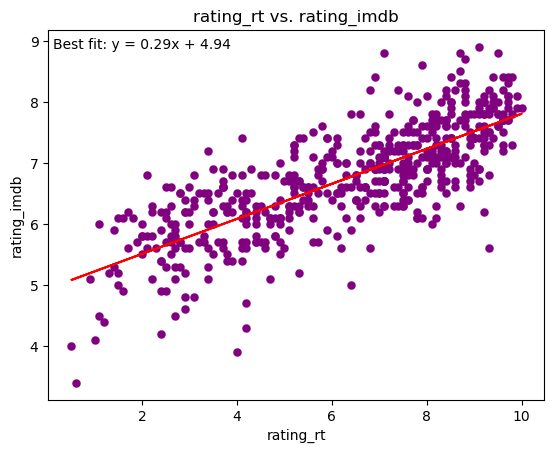

In [759]:
scatter_plot(ratings, 'rating_rt', 'rating_imdb')

As expected, IMDB rating has a strong positive relationship with RT rating. However, the typical range of IMDB ratings lies in the 5-8 point range, with no movie rated lower than 3 and no movie higher than 9. On the other hand, RT ratings vary widely all the way from 0 to 10 (0% to 100% on the RT site). This is most likely due to the fact that RT Tomatometer scores are simply a ratio of the amount of 'positive' reviews to the amount of total reviews, as opposed to a specific scale (like IMDB). 

### Step 4: Ratings vs. Global Gross

In [760]:
# select all of the columns for ratings, as well as the total earnings column
rvg = finale[['rating_rt', 'audience_score_rt', 'rating_imdb', 'global_gross']].dropna()

In [761]:
# normalize the imdb ratings so that all are on the same scale
rvg.rating_imdb = rvg.rating_imdb * 10

In [762]:
# take the log of earnings
# (this helps the plot gain more visibility)
rvg['log_gross'] = np.log10(rvg.global_gross)

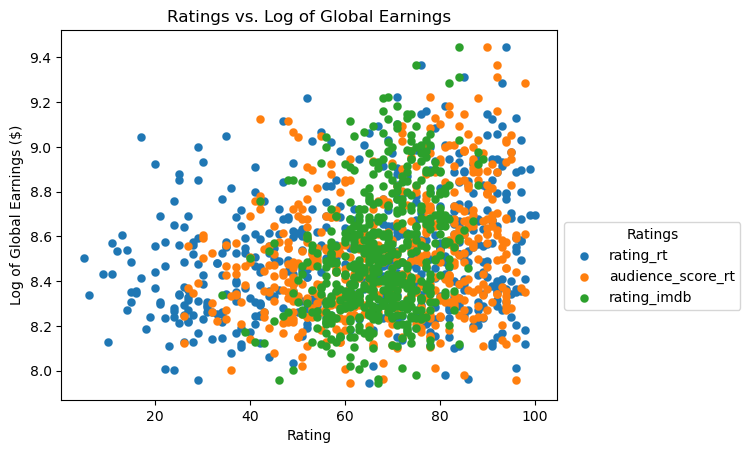

In [763]:
# iterate over the different ratings, plotting each one as a scatterplot
for col in rvg.columns[:3]:
    plt.scatter(rvg[col], rvg['log_gross'], label=col, linewidths=0.1)
plt.title('Ratings vs. Log of Global Earnings')
plt.xlabel('Rating')
plt.ylabel('Log of Global Earnings ($)')
plt.legend(title='Ratings', bbox_to_anchor=(1, 0.5))
plt.show()

Here we looked at the earnings for each of the films based on their ratings on IMDB and RT. In order to more clearly see the differences between the ratings, we took the log10 of earnings as opposed to just the earnings. Judging by the graph, we can see that there seems to be little correlation between the ratings of a movie and how much it earns. Despite this, the films that earned the most in this dataset (above \\$1-2billion) all tend to have higher reviews than the typical film. 

### Step 5: Gross Earnings Over Time

In [764]:
# select the years and global earnings of each film
geot = finale[['year', 'global_gross']].dropna()

In [765]:
# group by year and get the average earnings across each respective year
grpby = geot.groupby(by='year').agg(np.mean).reset_index()
grpby.head()

,year,global_gross
0,1937,418200000.0
1,1939,402382193.0
2,1940,84254167.0
3,1942,267447150.0
4,1950,93141149.0


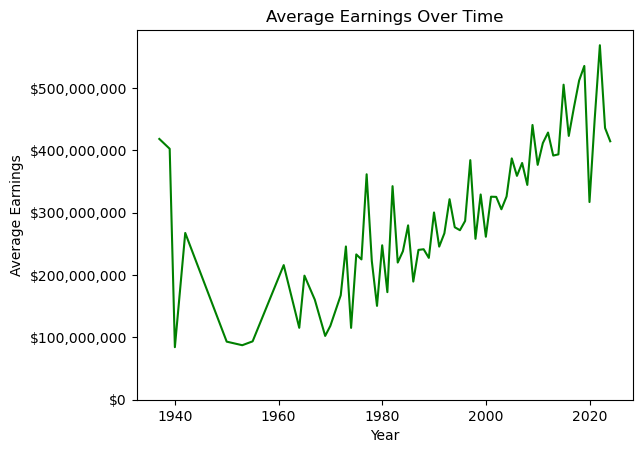

In [766]:
# plot the average earnings over time
plt.title('Average Earnings Over Time')
plt.plot(grpby.year, grpby.global_gross, color='green', ls='-')
plt.xlabel('Year')
plt.ylabel('Average Earnings')
# adjust the y-axis so that is displays dollar values instead of scientific notation
plt.yticks(range(0, 6*(10**8), 10**8), [f'${x:,}' for x in range(0, 6*(10**8), 10**8)])
plt.show()

The plot demonstrates that the average earnings for blockbuster films has increased steadily over time from around \\$100mil to over \\$500mil between 1940 and 2020. There are of course some discrepancies, mostly due to the small sample size for films made before 1960, and the notable droop in earnings in 2020 (due to COVID-19). 

### Step 6: Highest Earning Directors

In [767]:
# select the directors and total earnings
direcs = finale[['director_imdb', 'global_gross']].dropna()
# group by director(s) and get the sum of all of their films
grpby = direcs.groupby(by='director_imdb').agg(np.sum).reset_index()
grpby.head()

,director_imdb,global_gross
0,"""Gavin OConnor""",1.551600e+08
1,"Aaron Blaise, Robert Walker",2.503978e+08
2,"Aaron Horvath, Michael Jelenic, Pierre Leduc",1.362038e+09
3,"Aaron Nee, Adam Nee",1.929077e+08
4,Adam McKay,7.250336e+08


In [768]:
# get the top 15 directors by the total earnings of their blockbuster films
top15 = grpby.sort_values(by='global_gross', ascending=False)[:15]

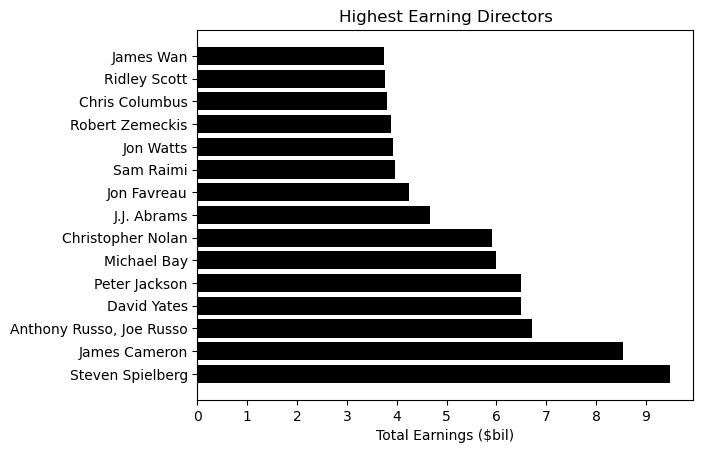

In [769]:
# plot a horizontal bar chart that shows each of the top 15 directors with their 
# respective films' total earnings
plt.title('Highest Earning Directors')
plt.xlabel('Total Earnings ($bil)')
plt.barh(y=top15.director_imdb, width=top15.global_gross, color='black')
plt.xticks(range(0, 10**10, 10**9), [f'{x:,}' for x in range(10)])
plt.show()

From this list of the highest earings directors, we can see that Steven Spielberg, James Cameron, and the Russo Brothers all have films that have earned more than \\$6bil total. This is of course not a robust list, as only the top ~1000 highest-earning films are considered in this dataset. 

### Step 7: Budget vs. Global Earnings Ratio

In [770]:
# get the titles, budget and earnings for each film
bvge = finale[['title_imdb', 'budget', 'global_gross']].dropna()

In [771]:
# create a column that calculates the ratio of a films earnings to its budget
bvge['ratio'] = bvge.global_gross / bvge.budget

In [794]:
# sort each of the two datasets by the films with the highest ratio and the lowest ratio
topfilm = bvge.sort_values(by='ratio', ascending=False)
botfilm = bvge.sort_values(by='ratio', ascending=True)

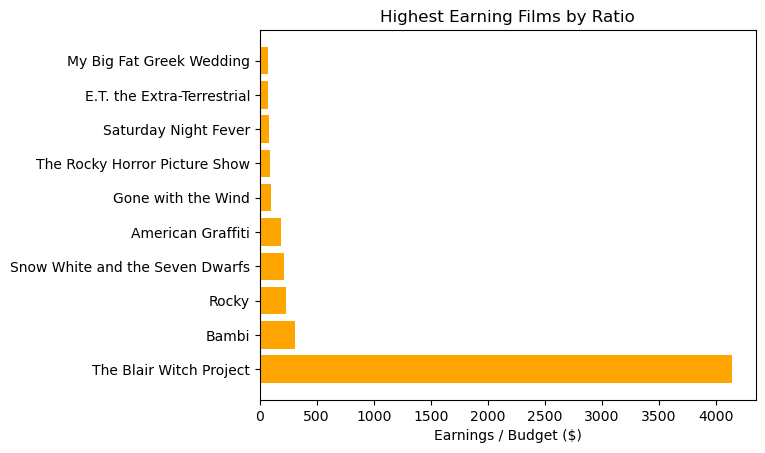

In [796]:
# plot a horizontal bar graph of the films with the highest ratio
plt.title('Highest Earning Films by Ratio')
plt.xlabel('Earnings / Budget ($)')
plt.barh(y=topfilm[:10].title_imdb, width=topfilm[:10].ratio, color='orange')
plt.show()

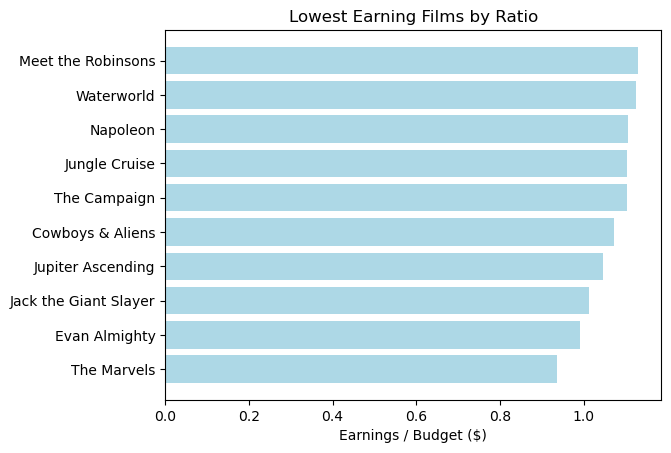

In [801]:
# plot a horizontal bar graph of the films with the lowest ratio
plt.title('Lowest Earning Films by Ratio')
plt.xlabel('Earnings / Budget ($)')
plt.barh(y=botfilm[:10].title_imdb, width=botfilm[:10].ratio, color='lightblue')
plt.show()

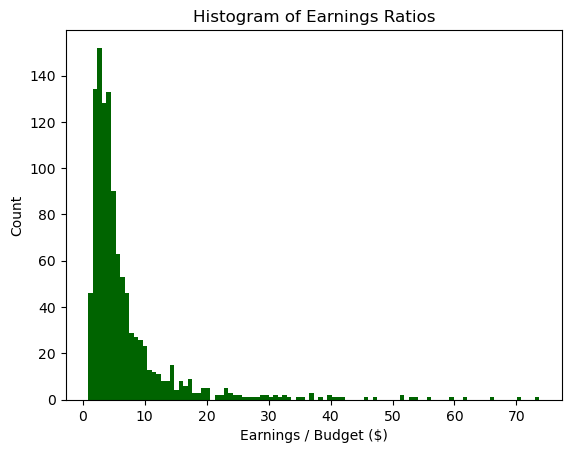

In [808]:
# display a histogram of the earnings ratios
plt.title('Histogram of Earnings Ratios')
plt.xlabel('Earnings / Budget ($)')
plt.ylabel('Count')
# omit the top 10 films by ratio, as they are significant outliers that would skew the scale of the graph
plt.hist(topfilm.ratio[10:], bins=100, color='darkgreen')
plt.show()

As is clearly seen by the first plot, the Blair Witch Project is a significant outlier with its earnings ratio of over 4000 to 1. This film is notable for its guerilla marketing tactics, becoming a blockbuster despite its bare-bones budget. Additionally, several older films (e.g. Bambi, Snow White, Gone with the Wind) had significantly higher earnings ratios than average. This is most likely due to older films tending to have significantly lower budgets compared to how many people saw them at the time.  

As for the films with the lowest ratio, we can see that there are only a few films that failed to earn as much as their budget - The Marvels, Evan Almighty, and Jack the Giant Slayer. Despite their low earnings, they still made the list of top 1000 highest earning films. Even though they earned a substantial sum of money at the box office, these profits were simply outweighed by their massive budgets. 

Taking a look at the histogram for these ratios, we see that the vast majority of blockbuster films earn somewhere between 1-5x their budget. 

## Final Thoughts and Implications

This project looked at the top 1000 highest earning films, how much they earn, how critics view them, and what factors could contribute to them becoming blockbusters. First, a flat file containing over 140,000 films was extracted and cleaned from the Rotten Tomatoes (RT) database. Subsequently, website data from boxofficemojo (subordinate to IMDB) was used to produce a dataset of the top 1000 highest-earning films. This dataset was further supplemented by making calls to the IMDB API. Once movie data was gathered from both the IMDB and RT databases into dataframes, all this data was merged and added to an SQLite database. 
	
    
The Rotten Tomatoes data was filtered significantly, as only a small fraction of the films and TV shows in the dataset were relevant to the project at hand. The IMDB data was overall easier to work with and more robust, as the API was able to find the appropriate film given a search query for the majority of queries. One of the biggest challenges in the project was merging the IMDB data and Rotten Tomatoes data together. For a large portion of films, there were significant stylistic differences in how their titles were presented – e.g. using different special characters, including the director in the title, and including a preamble. It was decided that the easiest way would be to find commonalities between IMDB and RT that would describe a film without needing the title. The easiest way to do this was to use the release date of the film along with its runtime. This is because it would be very unlikely for a film to be released on the same day, be the same length and earn a high amount.  This ended up being somewhat effective, as over half of the top 1000 films were able to be merged correctly despite the differences in title conventions. 
    
    
Rotten Tomatoes data was gathered via a third-party source (Kaggle), with the contributor of the dataset ensuring ethical web-scraping practices were applied to retrieve the data.  IMDB data was primarily extracted via the python Cinemagoer module, which is a means of making requests to the IMDB site through an API. IMDB guidelines state that scraped data cannot be used for commercial gain, so as this is simply an educational project, this would not have applied. Additionally, due to discrepancies between the information contained in the Rotten Tomatoes and IMDB datasets, it would be difficult to make conclusive assertions from the data gathered.